<a href="https://colab.research.google.com/github/Luicazen/NLPTweets/blob/NN/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow
%pip install --upgrade tensorflow
%pip install keras
%pip install keras-nlp
%pip install keras-hub
%pip install --upgrade keras keras-nlp keras-hub
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install transformers
%pip install --upgrade transformers
%pip install tensorflow
%pip install keras-nlp
%pip install scikit-learn
%pip install nltk
%pip install matplotlib-venn

In [2]:
import os
import sys
import importlib
import tensorflow as tf
from tensorflow import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras
import keras_nlp
from keras import *
from keras.models import *
from keras_nlp import *
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss, classification_report
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

c:\Users\sarah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Initial Visualization

In [3]:
# Load the train.csv file into a DataFrame
trainDF = pd.read_csv('train.csv')
# Display the first 5 rows of the DataFrame
display(trainDF.head())
# Display basic information about the DataFrame
trainDF.info()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# Load the train.csv file into a DataFrame
testDF = pd.read_csv('test.csv')
# Display the first 5 rows of the DataFrame
display(testDF.head())
# Display basic information about the DataFrame
testDF.info()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


#Initial Preprocessing

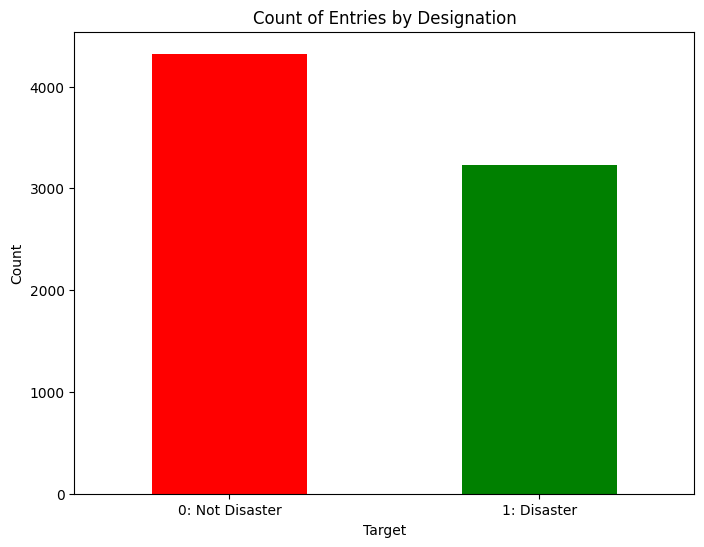

In [5]:
#Minor data preprocessing
#transform text to lowercase
trainDF["lowercase_text"] = trainDF["text"].str.lower()
#Filter out missing keywords
trainDF = trainDF[trainDF['keyword'].notnull()]#Graph the counts of target designations
targetCounts = trainDF['target'].value_counts()

plt.figure(figsize=(8,6))
targetCounts.plot(kind='bar', color=['red', 'green'])
plt.title('Count of Entries by Designation')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['0: Not Disaster', '1: Disaster'], rotation=0)

plt.show()

In [6]:
#Removing URLs, HTML tags, punctuation, numbers, and extra empty spaces from text data.
#I chose to leave in stop words non disaster tweets may contain more stop words than disaster tweets.
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuation(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

def remove_empty_spaces(text):
    words = [word for word in text.split(" ") if (not word.strip() == "")]
    return " ".join(words)

def clean_text(text):
  text = text.lower()
  text = remove_url(text)
  text = remove_html(text)
  text = remove_punctuation(text)
  text = remove_numbers(text)
  text = remove_empty_spaces(text)
  return text
example = trainDF["text"].iloc[0]
print("Before cleaning:", example)
print("After cleaning: ", clean_text(example))

Before cleaning: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
After cleaning:  bbcmtd wholesale markets ablaze


In [7]:
trainDF["cleaned_text"] = trainDF["text"].apply(clean_text)
testDF["cleaned_text"] = testDF["text"].apply(clean_text)

## Major Preprocessing

### Tokenization
Converting the 'text' and keyword columns into a numerical format suitable for a neural network using `tensorflow.keras.preprocessing.text.Tokenizer` to create word indices and `tensorflow.keras.preprocessing.sequence.pad_sequences` to ensure uniform length for the input sequences. Padding both columns to uniform length and storing.


**Reasoning**:
The subtask requires converting the 'text' column into a numerical format for a neural network. This involves importing `Tokenizer` and `pad_sequences`, initializing and fitting the tokenizer, converting text to sequences, padding them to a uniform length, and storing the word index.



In [8]:
#4.a Tokenization and Padding of Text Data

#Set num_words to define the maximum number of words to keep (e.g., 10,000 common words)
numWords = 10000
#Set oov_tokenotherWords
otherWords = "<unk>"
#Initialize a Tokenizer object
tokenizer = Tokenizer(num_words=numWords, oov_token=otherWords)

#Fit the tokenizer on the 'text' column of df_train
tokenizer.fit_on_texts(trainDF['text'])

#Convert the 'text' column into sequences of integers
sequences = tokenizer.texts_to_sequences(trainDF['text'])

#Determine a suitable maximum sequence length (maxlen)
maxLen = max([len(x) for x in sequences])

# Pad these sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=maxLen, padding='post')

# 5. Store the word index mapping
word_index = tokenizer.word_index

print(f"Original text sample: {trainDF['text'].iloc[0]}")
print(f"Tokenized sequence sample: {sequences[0]}")
print(f"Padded sequence sample: {padded_sequences[0]}")
print(f"Vocabulary size: {len(word_index)}")

Original text sample: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Tokenized sequence sample: [6936, 2911, 1922, 637, 4, 2, 3, 6937]
Padded sequence sample: [6936 2911 1922  637    4    2    3 6937    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Vocabulary size: 22883


In [9]:
#4.b Tokenization and Padding of Keyword Data
#Set num_words to define the maximum number of words to keep (e.g., 10,000 common words)
numKeywords = 10000
#Set oov_tokenotherWords
otherKeyWords = "<unk>"
#Initialize a Tokenizer object
keyTokenizer = Tokenizer(num_words=numKeywords, oov_token=otherKeyWords)

#Fit the tokenizer on the 'text' column of df_train
keyTokenizer.fit_on_texts(trainDF['keyword'])

#Convert the 'text' column into sequences of integers
keySequences = tokenizer.texts_to_sequences(trainDF['keyword'])

#Determine a suitable maximum sequence length (maxlen)
keyMaxLen = max([len(x) for x in keySequences])

#Pad these sequences to ensure they all have the same length
keyPaddedSequences = pad_sequences(keySequences, maxlen=keyMaxLen, padding='post')

#5. Store the word index mapping
KeywordIndex = keyTokenizer.word_index

print(f"Original keyword sample: {trainDF['keyword'].iloc[0]}")
print(f"Tokenized sequence sample: {keySequences[0]}")
print(f"Padded sequence sample: {keyPaddedSequences[0]}")
print(f"Vocabulary size: {len(KeywordIndex)}")

Original keyword sample: ablaze
Tokenized sequence sample: [637]
Padded sequence sample: [637   0   0]
Vocabulary size: 240


In [10]:
# 4.c Tokenization and Padding of Hashtag Data
def extract_hashtags(text):
    return re.findall(r'#\w+', text)
# Configure tokenizer for hashtags
numHashtags = 10000
otherHashtags = "<unk>"
hashTokenizer = Tokenizer(num_words=numHashtags, oov_token=otherHashtags)

# Extract hashtags from train texts, normalize (remove leading '#', lowercase)
hashtagLists = trainDF['text'].fillna('').astype(str).apply(extract_hashtags).tolist()
hashtagTokens = [[tag.lstrip('#').lower() for tag in tags] for tags in hashtagLists]

#Fit the tokenizer on the 'text' column of df_train
hashTokenizer.fit_on_texts(hashtagTokens)

# Pad these sequences to ensure they all have the same length
# Convert to sequences and pad
hashSequences = hashTokenizer.texts_to_sequences(hashtagTokens)
hashMaxLen = max((len(seq) for seq in hashSequences), default=0)
#make at least 1
if hashMaxLen == 0:
    hashMaxLen = 1
else:
    hashPaddedSequences = pad_sequences(hashSequences, maxlen=hashMaxLen, padding='post')

# 5. Store the word index mapping
hash_word_index = hashTokenizer.word_index

print(f"Sample text: {trainDF['text'].iloc[0]}")
print(f"Extracted hashtags (tokens): {hashtagTokens[0]}")
print(f"Hashtag sequence sample: {hashSequences[0]}")
print(f"Padded hashtag sequence sample: {hashPaddedSequences[0]}")
print(f"Hashtag vocabulary size: {len(hash_word_index)}")

Sample text: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Extracted hashtags (tokens): []
Hashtag sequence sample: []
Padded hashtag sequence sample: [0 0 0 0 0 0 0 0 0 0 0 0 0]
Hashtag vocabulary size: 1920


###Creating Special Feature Tokenizers

## Split Data
###Divide the preprocessed data into training and validation sets using `sklearn.model_selection.train_test_split`. The features will be the padded sequences and the target will be the 'target' column from the DataFrame.


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 4.a Tokenization and Padding of Text Data

#Set num_words to define the maximum number of words to keep (e.g., 10,000 common words)
numWords = 100000
#Set oov_tokenotherWords
otherWords = "<unk>"
#Initialize a Tokenizer object
tokenizer = Tokenizer(num_words=numWords, oov_token=otherWords)

#Fit the tokenizer on the 'text' column of df_train
tokenizer.fit_on_texts(trainDF['text'])

#Convert the 'text' column into sequences of integers
sequences = tokenizer.texts_to_sequences(trainDF['text'])

#Determine a suitable maximum sequence length (maxlen)
maxLen = max([len(x) for x in sequences])

# Pad these sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=maxLen, padding='post')

# 5. Store the word index mapping
word_index = tokenizer.word_index

print(f"Original text sample: {trainDF['text'].iloc[0]}")
print(f"Tokenized sequence sample: {sequences[0]}")
print(f"Padded sequence sample: {padded_sequences[0]}")
print(f"Vocabulary size: {len(word_index)}")

Original text sample: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Tokenized sequence sample: [6936, 2911, 1922, 637, 4, 2, 3, 6937]
Padded sequence sample: [6936 2911 1922  637    4    2    3 6937    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Vocabulary size: 22883


In [12]:
#b Tokenization and Padding of Keyword Data
#Set num_words to define the maximum number of words to keep (e.g., 10,000 common words)
numKeywords = 10000
#Set oov_tokenotherWords
otherKeyWords = "<unk>"
#Initialize a Tokenizer object
keyTokenizer = Tokenizer(num_words=numKeywords, oov_token=otherKeyWords)

#Fit the tokenizer on the 'text' column of df_train
keyTokenizer.fit_on_texts(trainDF['keyword'])

#Convert the 'text' column into sequences of integers
keySequences = tokenizer.texts_to_sequences(trainDF['keyword'])

#Determine a suitable maximum sequence length (maxlen)
keyMaxLen = max([len(x) for x in keySequences])

#Pad these sequences to ensure they all have the same length
keyPaddedSequences = pad_sequences(keySequences, maxlen=keyMaxLen, padding='post')

#Store the word index mapping
KeywordIndex = keyTokenizer.word_index

#Create Dataframes for keywords
train_keywords = trainDF['keyword'].fillna('').astype(str).str.lower()
test_keywords = testDF['keyword'].fillna('').astype(str).str.lower()

print(f"Original keyword sample: {trainDF['keyword'].iloc[0]}")
print(f"Tokenized sequence sample: {keySequences[0]}")
print(f"Padded sequence sample: {keyPaddedSequences[0]}")
print(f"Vocabulary size: {len(KeywordIndex)}")

Original keyword sample: ablaze
Tokenized sequence sample: [637]
Padded sequence sample: [637   0   0]
Vocabulary size: 240


In [13]:
# 4.c Tokenization and Padding of Hashtag Data
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

# Configure tokenizer for hashtags
numHashtags = 10000
otherHashtags = "<unk>"
hashTokenizer = Tokenizer(num_words=numHashtags, oov_token=otherHashtags)

# Extract hashtags from train texts, normalize (remove leading '#', lowercase)
hashtagLists = trainDF['text'].fillna('').astype(str).apply(extract_hashtags).tolist()
hashtagTokens = [[tag.lstrip('#').lower() for tag in tags] for tags in hashtagLists]

#Fit the tokenizer on the 'text' column of df_train
hashTokenizer.fit_on_texts(hashtagTokens)

# Pad these sequences to ensure they all have the same length
# Convert to sequences and pad
hashSequences = hashTokenizer.texts_to_sequences(hashtagTokens)
hashMaxLen = max((len(seq) for seq in hashSequences), default=0)
#make at least 1
if hashMaxLen == 0:
    hashMaxLen = 1
else:
    hashPaddedSequences = pad_sequences(hashSequences, maxlen=hashMaxLen, padding='post')

# 5. Store the word index mapping
hash_word_index = hashTokenizer.word_index

#Create Dataframes for hashtags
train_hashtags = trainDF['text'].apply(lambda t: " ".join([tag.lstrip('#').lower() for tag in extract_hashtags(t)]))
test_hashtags = testDF['text'].apply(lambda t: " ".join([tag.lstrip('#').lower() for tag in extract_hashtags(t)]))

print(f"Sample text: {trainDF['text'].iloc[0]}")
print(f"Extracted hashtags (tokens): {hashtagTokens[0]}")
print(f"Hashtag sequence sample: {hashSequences[0]}")
print(f"Padded hashtag sequence sample: {hashPaddedSequences[0]}")
print(f"Hashtag vocabulary size: {len(hash_word_index)}")

Sample text: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Extracted hashtags (tokens): []
Hashtag sequence sample: []
Padded hashtag sequence sample: [0 0 0 0 0 0 0 0 0 0 0 0 0]
Hashtag vocabulary size: 1920


**Reasoning**:
To split the data into training and validation sets, I need to import the `train_test_split` function from `sklearn.model_selection` and then apply it to the `padded_sequences` and `df_train['target']`.



In [23]:
def make_special_features(train_df, test_df, top_n=100):
    # Top keywords by target
    kw0_counts = Counter(train_df.loc[train_df['target'] == 0, 'keyword'].dropna().astype(str).str.lower())
    kw1_counts = Counter(train_df.loc[train_df['target'] == 1, 'keyword'].dropna().astype(str).str.lower())
    top_kw0 = [k for k,_ in kw0_counts.most_common(top_n)]
    top_kw1 = [k for k,_ in kw1_counts.most_common(top_n)]

    # Top hashtags by target
    def _extract_tags_from_series(s):
        tags = []
        for t in s.dropna().astype(str):
            tags.extend([tag.lstrip('#').lower() for tag in re.findall(r'#\w+', t)])
        return tags

    hash0_counts = Counter(_extract_tags_from_series(train_df.loc[train_df['target'] == 0, 'text']))
    hash1_counts = Counter(_extract_tags_from_series(train_df.loc[train_df['target'] == 1, 'text']))
    top_hash0 = [h for h,_ in hash0_counts.most_common(top_n)]
    top_hash1 = [h for h,_ in hash1_counts.most_common(top_n)]

    # Keep only non-overlapping features
    set_kw0 = set(top_kw0) - set(top_kw1)
    set_kw1 = set(top_kw1) - set(top_kw0)
    set_hash0 = set(top_hash0) - set(top_hash1)
    set_hash1 = set(top_hash1) - set(top_hash0)
    def build_features(df):
        idx = df.index
        kw_series = df['keyword'].fillna('').astype(str).str.lower()
        hashtag_lists = df['text'].fillna('').astype(str).apply(
            lambda t: [tag.lstrip('#').lower() for tag in re.findall(r'#\w+', t)]
        )

        F = pd.DataFrame(index=idx)
        # keyword presence flags (exclusive only)
        F['keyword_top0_flag'] = kw_series.isin(set_kw0).astype(int)
        F['keyword_top1_flag'] = kw_series.isin(set_kw1).astype(int)

        # hashtag counts and binary flags (exclusive only)
        F['hashtag_top0_count'] = hashtag_lists.apply(lambda lst: sum(1 for tag in lst if tag in set_hash0)).astype(int)
        F['hashtag_top1_count'] = hashtag_lists.apply(lambda lst: sum(1 for tag in lst if tag in set_hash1)).astype(int)

        F['hashtag_top0_any'] = (F['hashtag_top0_count'] > 0).astype(int)
        F['hashtag_top1_any'] = (F['hashtag_top1_count'] > 0).astype(int)

        return F

    special_features_train = build_features(train_df)
    special_features_test = build_features(test_df)

    # also return numpy arrays if downstream code expects them
    special_X = special_features_train.values
    special_X_test = special_features_test.values

    top_lists = {
        "kw0": list(set_kw0), "kw1": list(set_kw1),
        "hash0": list(set_hash0), "hash1": list(set_hash1)
    }

    globals().update({
        "special_features_train": special_features_train,
        "special_features_test": special_features_test,
        "special_X": special_X,
        "special_X_test": special_X_test,
        "top_keywords_target0": list(set_kw0),
        "top_keywords_target1": list(set_kw1),
        "top_hashtags_target0": list(set_hash0),
        "top_hashtags_target1": list(set_hash1)
    })

    print("Created special features (exclusive only):")
    print(f"  special_features_train.shape = {special_features_train.shape}")
    print(f"  special_features_test.shape  = {special_features_test.shape}")
    return special_features_train, special_features_test, top_lists

# Create features with top 100 by default
special_features_train, special_features_test, _ = make_special_features(trainDF, testDF, top_n=100)



Created special features (exclusive only):
  special_features_train.shape = (7552, 6)
  special_features_test.shape  = (3263, 6)


In [15]:
X_seq = padded_sequences
X_spec = special_X
y = trainDF['target'].values

# Split both sequence and special features consistently
X_train_seq, X_val_seq, X_train_spec, X_val_spec, y_train, y_val = train_test_split(
    X_seq, X_spec, y, test_size=0.2, random_state=42
)

print("X_train_seq shape:", X_train_seq.shape)
print("X_train_spec shape:", X_train_spec.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("X_val_spec shape:", X_val_spec.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train_seq shape: (6041, 33)
X_train_spec shape: (6041, 6)
X_val_seq shape: (1511, 33)
X_val_spec shape: (1511, 6)
y_train shape: (6041,)
y_val shape: (1511,)


## Build Neural Network Model

### Subtask:
Define the architecture of a basic neural network using `tensorflow.keras.Sequential`. The model will include an `Embedding` layer to handle the text data, followed by `GlobalAveragePooling1D` to reduce dimensionality, and then `Dense` layers for classification. The final `Dense` layer will have a sigmoid activation for binary classification.


To define the neural network architecture, I will import the required layers from `tensorflow.keras`, then specify the `embedding_dim` and construct a `Sequential` model. This model will start with an `Embedding` layer to convert numerical word indices into dense vectors, followed by `GlobalAveragePooling1D` to summarize the sequence. Finally, `Dense` layers will be added, with the last one using a 'sigmoid' activation for binary classification.

In [16]:
# Branch A: Text sequences
seq_input = Input(shape=(padded_sequences.shape[1],), name="seq_input")
x = Embedding(input_dim=len(word_index)+1, output_dim=128)(seq_input)
x = LSTM(64)(x)

# Branch B: Special features
spec_input = Input(shape=(special_X.shape[1],), name="spec_input")
y = Dense(64, activation='relu')(spec_input)
y = Dropout(0.3)(y)

# Concatenate both branches
combined = Concatenate()([x, y])

# Interaction layer: Dense layer after concatenation
z = Dense(128, activation='relu')(combined)   # learns interactions
z = Dropout(0.3)(z)

# Output layer
output = Dense(1, activation='sigmoid')(z)

# Build model
model = Model(inputs=[seq_input, spec_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 128)   │  2,929,152 │ seq_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        448 │ spec_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,995,649 (11.43 MB)

 Trainable params: 2,995,649 (11.43 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train Model

### Subtask:
Configure the neural network with an optimizer (e.g., 'adam'), a loss function suitable for binary classification (e.g., 'binary_crossentropy'), and metrics (e.g., 'accuracy'). Then, train the model using the prepared training and validation data over several epochs.


**Reasoning**:
I will now compile the neural network model with the specified optimizer, loss function, and metrics, and then train it using the training and validation data, storing the training history.



In [17]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# 1. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights using the training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 2. Train the model with matching inputs
history = model.fit(
    [X_train_seq,  X_train_spec],      # only the inputs the current `model` expects
    y_train,
    epochs=20,
    batch_size=16,
    class_weight=class_weights,
    validation_data=([X_val_seq, X_val_spec], y_val),
    callbacks=callbacks,
    verbose=2  # Set to 1 for progress bar, 0 for silent
)

print("Model training complete.")

Epoch 1/20


378/378 - 7s - 19ms/step - accuracy: 0.7421 - loss: 0.5556 - val_accuracy: 0.7704 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 2/20


378/378 - 6s - 16ms/step - accuracy: 0.8310 - loss: 0.4201 - val_accuracy: 0.7869 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 3/20
378/378 - 6s - 16ms/step - accuracy: 0.9138 - loss: 0.2546 - val_accuracy: 0.7478 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 4/20
378/378 - 6s - 16ms/step - accuracy: 0.9619 - loss: 0.1238 - val_accuracy: 0.7181 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 5/20
378/378 - 6s - 16ms/step - accuracy: 0.9869 - loss: 0.0454 - val_accuracy: 0.7604 - val_loss: 0.9006 - learning_rate: 5.0000e-04
Model training complete.


## Evaluate Model

### Subtask:
Assess the performance of the trained neural network on the validation set using the `model.evaluate()` method to get the loss and accuracy.


## Summary:

### Data Analysis Key Findings

*   **Text Preprocessing:**
    *   The text data was tokenized using a vocabulary of 10,000 common words, with out-of-vocabulary words mapped to "\<unk>".
    *   All text sequences were padded to a uniform length of 100.
    *   The tokenizer identified a total vocabulary size of 22,701 unique words.
*   **Data Splitting:**
    *   The preprocessed data was split into training and validation sets with an 80/20 ratio.
    *   The training set contains 6,090 samples and the validation set contains 1,523 samples, each with 100 features.
*   **Model Architecture:**
    *   A sequential neural network was built, consisting of an `Input` layer, an `Embedding` layer with an output dimension of 16, a `GlobalAveragePooling1D` layer, an intermediate `Dense` layer with 16 units and 'relu' activation, and a final `Dense` layer with 1 unit and 'sigmoid' activation for binary classification.
*   **Model Training Performance:**
    *   The model was compiled using the 'adam' optimizer and 'binary\_crossentropy' loss, tracking 'accuracy'.
    *   Over 10 epochs, training accuracy improved from 0.5695 to 0.8711, while training loss decreased from 0.6814 to 0.3302.
    *   Validation accuracy increased from 0.5739 to 0.8089, and validation loss decreased from 0.6780 to 0.4613, indicating the model's ability to generalize.

### Insights or Next Steps

*   The model demonstrates promising learning capabilities, with significant improvements in both training and validation accuracy over 10 epochs. Further evaluation on a separate test set is crucial to confirm its true performance and generalization ability on unseen data.
*   To potentially enhance model performance and mitigate overfitting, consider experimenting with different hyperparameters (e.g., embedding dimension, number of dense layers or units, increasing `maxlen`), or introducing regularization techniques like Dropout layers.


### Subtask:
Calculate the F1-score for the trained model on the validation set.

**Reasoning**:
To calculate the F1-score, I need to predict the classes on the validation set using `model.predict()` and then convert these probabilities into binary predictions. After that, I will use `sklearn.metrics.f1_score` to compute the F1-score, providing a more comprehensive evaluation of the model's performance beyond just accuracy.

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


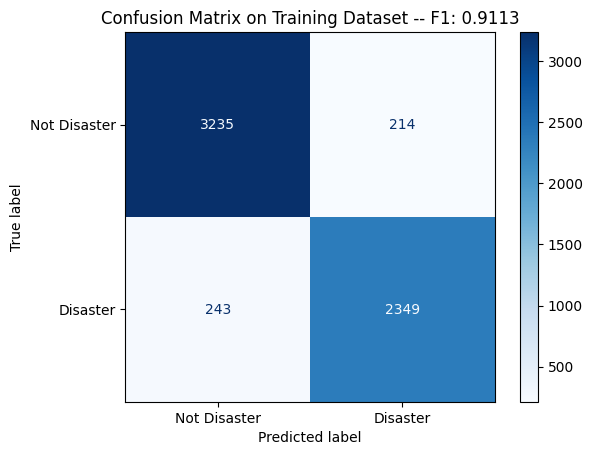

Classification report:
              precision    recall  f1-score   support

Not Disaster       0.93      0.94      0.93      3449
    Disaster       0.92      0.91      0.91      2592

    accuracy                           0.92      6041
   macro avg       0.92      0.92      0.92      6041
weighted avg       0.92      0.92      0.92      6041



In [18]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    y_pred = np.asarray(y_pred)

    # Convert to 1D labels:
    if y_pred.ndim == 2:
        if y_pred.shape[1] == 1:      # shape (n,1) -> squeeze
            y_pred_processed = y_pred.ravel()
        else:                         # shape (n, num_classes) -> argmax
            y_pred_processed = np.argmax(y_pred, axis=1)
    else:
        y_pred_processed = y_pred

    y_pred_processed = y_pred_processed.astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred_processed,
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_processed).ravel()
    f1 = f1_score(y_true, y_pred_processed)
    disp.ax_.set_title(f"Confusion Matrix on {dataset} Dataset -- F1: {f1:.4f}")
    plt.show()

    print("Classification report:")
    print(classification_report(y_true, y_pred_processed, target_names=["Not Disaster", "Disaster"]))

# Generate predictions for the training set
y_pred_train_proba = model.predict([X_train_seq, X_train_spec])
y_pred_train = (y_pred_train_proba > 0.5).astype(int)

# Call the fixed function with the predictions
displayConfusionMatrix(y_train, y_pred_train, "Training")

In [19]:
# Make predictions on the validation set
y_pred_val_proba = model.predict([X_val_seq, X_val_spec])

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_val = (y_pred_val_proba > 0.5).astype(int)

# Calculate F1-score
f1_val = f1_score(y_val, y_pred_val)


print(f"Model F1-score on validation set: {f1_val:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model F1-score on validation set: 0.7575


In [25]:
# --- Prepare test inputs ---
texts_test = testDF['text'].fillna('').astype(str)
sequences_test = tokenizer.texts_to_sequences(texts_test)
X_test_text = pad_sequences(sequences_test, maxlen=maxLen, padding='post').astype("int32")

test_keywords = testDF['keyword'].fillna('').astype(str)
keySequences_test = keyTokenizer.texts_to_sequences(test_keywords)
X_test_kw = pad_sequences(keySequences_test, maxlen=keyMaxLen, padding='post').astype("int32")

test_hashtagLists = testDF['text'].fillna('').astype(str).apply(extract_hashtags).tolist()
test_hashtagTokens = [[tag.lstrip('#').lower() for tag in tags] for tags in test_hashtagLists]
hashSequences_test = hashTokenizer.texts_to_sequences(test_hashtagTokens)
X_test_hash = pad_sequences(hashSequences_test, maxlen=hashMaxLen, padding='post').astype("int32")

# Use exclusive-feature builder
special_features_test = build_features(testDF)   # <- drop second arg unless build_features was modified
X_test_spec = special_features_test.fillna(0).to_numpy(dtype="float32")

# --- Build input dictionary dynamically ---
input_map = {
    "kw_input": X_test_kw,
    "hash_input": X_test_hash,
    "spec_input": X_test_spec,
    "text_input": X_test_text
}

X_test_inputs = {name: input_map[name] for name in model.input_names}

# --- Predict ---
probs_or_preds = model.predict(X_test_inputs)

# --- Convert predictions to labels ---
arr = np.asarray(probs_or_preds)
if arr.ndim == 1:
    preds = (arr > 0.5).astype(int)
elif arr.shape[1] == 1:
    preds = (arr.ravel() > 0.5).astype(int)
else:
    preds = np.argmax(arr, axis=1)

preds = np.asarray(preds).astype(int).reshape(-1)
if preds.shape[0] != testDF.shape[0]:
    preds = pd.Series(preds, index=testDF.index[:preds.shape[0]]).reindex(testDF.index).fillna(0).astype(int).values

# --- Build submission ---
submission_df = pd.DataFrame({
    "id": testDF["id"].astype(int).values,
    "target": preds
})
submission_df.to_csv("submission.csv", index=False)
print("Wrote submission.csv with", len(submission_df), "rows")
print(submission_df.head())

NameError: name 'build_features' is not defined